In [1]:
import numpy as np
# from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
# from sklearn.manifold import t_sne
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import os
import kaldi_io
import torch
from tqdm import tqdm
from scipy.stats import norm

plt.rc('font', family='Times New Roman', weight='semibold')

# import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 10)

In [2]:
data_dir = '/home/work2020/yangwenhao/project/SpeakerVerification-pytorch'

tdnn_xvector_dir = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/cnceleb_dev_epoch50_fix'
tdnn_xvector_dict = {}
with open(os.path.join(data_dir, tdnn_xvector_dir, 'xvectors.scp'), 'r') as f:
    for l in f.readlines():
        uid,upath = l.split()
        tdnn_xvector_dict[uid] = upath
    
spk2uid_dict = {}
for uid in tdnn_xvector_dict:
    sid,_,_,_ = uid.split('-')
    spk2uid_dict.setdefault(sid, []).append(uid)
        

In [3]:
tdnn_ckp_dir = 'Data/checkpoint/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/checkpoint_50.pth'
tdnn_model = torch.load(data_dir +"/"+tdnn_ckp_dir)

In [4]:
classifier_Center = tdnn_model['state_dict']['classifier.W'].cpu()
print(classifier_Center.shape)

classifier_Center[:,1].shape

torch.Size([512, 800])


torch.Size([512])

In [5]:
lstm_dir = '/home/work2020/yangwenhao/project/lstm_speaker_verification/data'

cnc_dir = 'cnceleb/dev/wav.scp'
spk_domain_dict = {}
domains = set([])

with open(os.path.join(lstm_dir, cnc_dir), 'r') as f:
    
    for l in f.readlines():
        uid,upath = l.split()
        
        sid, domain,_,_ = uid.split('-')
        domains.add(domain)
        if sid in spk_domain_dict:
            spk_domain_dict[sid].add(domain)
        else:
            spk_domain_dict[sid] = set([domain])


In [6]:
domains = list(domains)
domains.sort()
domain2idx = {uid:i**2 for i,uid in enumerate(domains)}

spks = list(spk_domain_dict.keys())
spks.sort()
spk2idx = {sid:i for i,sid in enumerate(spks)}

In [7]:
list(spk_domain_dict.keys())[:10]

['id00000',
 'id00001',
 'id00002',
 'id00003',
 'id00004',
 'id00005',
 'id00006',
 'id00007',
 'id00008',
 'id00009']

In [8]:
numofdomains = 4
for sid in spk_domain_dict:
    if len(spk_domain_dict[sid]) >= numofdomains:
        print(sid, end='", "')
# id00004

id00038", "id00047", "id00061", "id00070", "id00094", "id00096", "id00100", "id00108", "id00113", "id00130", "id00138", "id00152", "id00182", "id00210", "id00217", "id00222", "id00223", "id00258", "id00291", "id00304", "id00305", "id00307", "id00346", "id00351", "id00374", "id00376", "id00392", "id00394", "id00404", "id00406", "id00410", "id00412", "id00436", "id00448", "id00453", "id00458", "id00459", "id00464", "id00472", "id00476", "id00482", "id00489", "id00491", "id00498", "id00500", "id00504", "id00510", "id00522", "id00523", "id00533", "id00550", "id00555", "id00556", "id00557", "id00559", "id00601", "id00623", "id00664", "id00687", "id00693", "id00702", "id00738", "id00740", "id00747", "id00757", "id00769", "

In [9]:
# spk_domain_dict['id00007']
all_sids = ["id00047", "id00061", "id00070", "id00094"]

In [ ]:
plt.figure(figsize=(18,6))

for i,this_sid in enumerate(all_sids):
    ax = plt.subplot(2,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
#             print(this_vector.shape)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
    
#     print('1')
    one_xvectors = np.array(one_xvectors)
#     print(one_xvectors.shape)
    one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
    ax.scatter(one_embedded[:,0], one_embedded[:,1], c=one_xvectors_domidx, label=one_xvectors_dom)
    
    ax = plt.subplot(2,len(all_sids),len(all_sids)+i+1)
    [ax.scatter([dom]*len(one_xvectors_dom2cos[dom]), one_xvectors_dom2cos[dom]) for dom in one_xvectors_dom2cos]
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_ylim(0,1.0)
    ax.set_xticks
    ax.scatter(one_xvectors_dom2cos)
    
#     ax.legend(one_xvectors_dom)
#     print(set(one_xvectors_dom))
#     plt.legend(list(set(one_xvectors_dom)))
    

(100, 512)
(354, 512)
(241, 512)
(161, 512)
(201, 512)


In [ ]:
print(miss_uid[:10])

(0.0, 1.0)

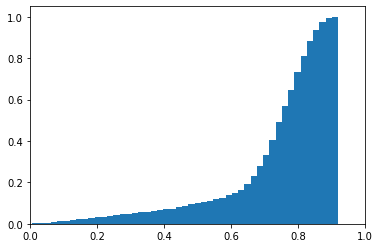

In [98]:
_ = plt.hist(all_cos, bins=50, density=True, cumulative=True)
plt.xlim(0,1)

100%|███████████████████████████████████████████████████████| 91824/91824 [00:09<00:00, 9818.46it/s]


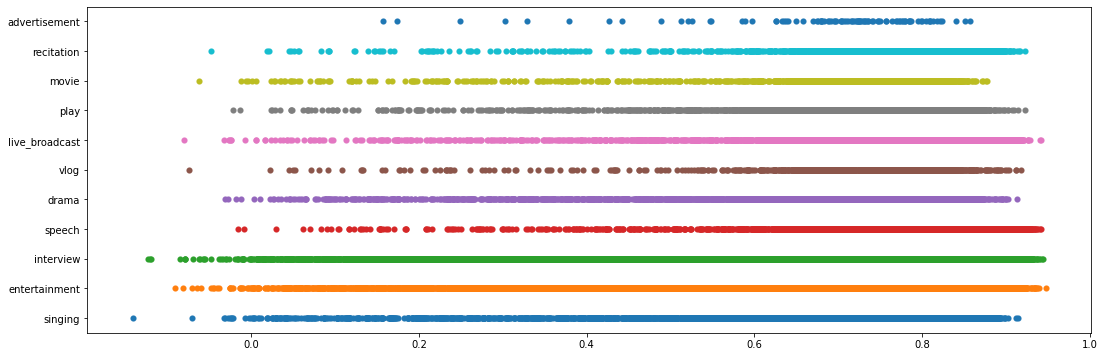

In [108]:
miss_uid = []
all_cos = []
dom2cos = {}

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 
    dom = uid.split('-')[1]
    dom2cos.setdefault(dom,[]).append(float(this_cos))


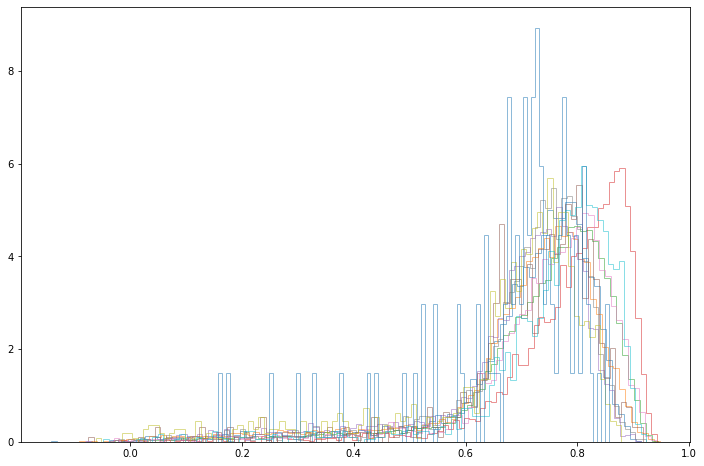

In [128]:
plt.figure(figsize=(12,8))
for i,dom in enumerate(dom2cos):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    plt.hist(dom_cos, alpha=0.5, bins=100, density=True, histtype='step')
    

<BarContainer object of 11 artists>

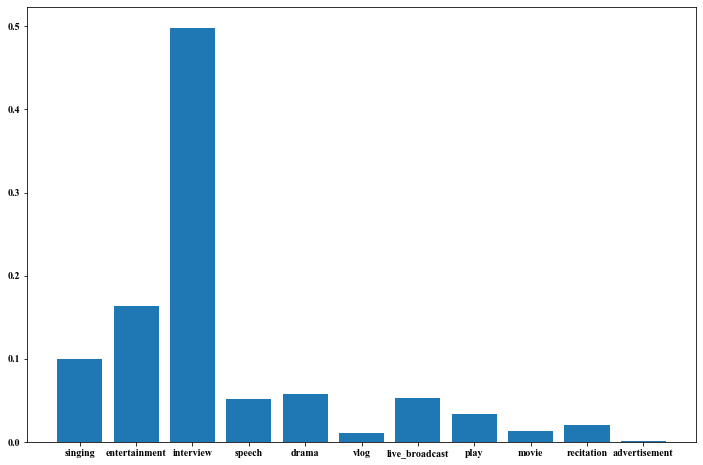

In [164]:
dom2num = []
domains = []
plt.figure(figsize=(12,8))
for i,dom in enumerate(dom2cos):
    domains.append(dom)
    dom2num.append(len(dom2cos[dom]))
    
plt.bar(domains, np.array(dom2num)/all_cos)
    

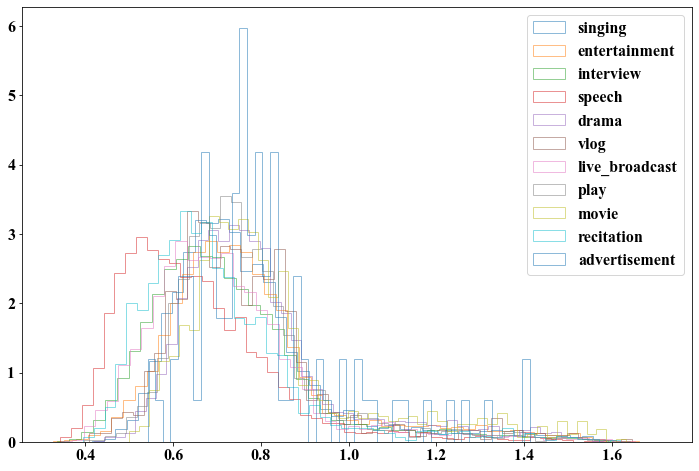

In [136]:
fontsize=16
plt.figure(figsize=(12,8))
for i,dom in enumerate(dom2cos):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    _ =plt.hist(np.arccos(dom_cos), alpha=0.5, bins=50, density=True, histtype='step')
plt.legend(list(dom2cos.keys()), fontsize=fontsize) 
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

In [138]:
from scipy.stats import norm
import statistics

In [157]:
all_cos = 0
for i,dom in enumerate(dom2cos):
    all_cos += len(dom2cos[dom])

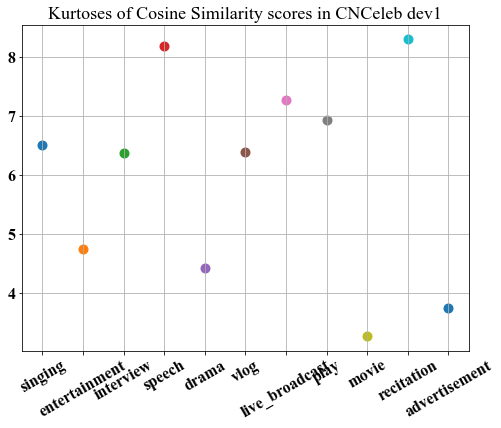

In [187]:
# x = np.arange(0, 2, 0.01)
plt.figure(figsize=(8,6))
plt.title("Kurtoses of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
# ax1 = plt.subplot(2,1,1)
# ax2 = plt.subplot(2,1,2)

for i,dom in enumerate(dom2cos):
    dom_cos = np.array(dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    
#     kurtoses *= len(dom_cos)/all_cos
#     skewness = np.mean(np.power(z_scores, 3.0))
#     print(kurtoses)
#     mean = statistics.mean(dom_cos)
#     sd = statistics.stdev(dom_cos)
#     plt.plot(x, norm.pdf(x, mean, sd))
    
    plt.scatter([dom], [kurtoses], marker='o', linewidth=4)
#     ax2.scatter([dom], [mean], marker='o', linewidth=4)
    
# plt.ylim(0,10)
# plt.xlim(0,1)
# ax1.set_xticks([])
plt.grid()

plt.tick_params(axis='x', labelrotation=30)
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# hard ==> easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation